Development of grid splitting of image for the 

In [20]:
%matplotlib notebook
from lsst.geom import Box2I, Point2I, Extent2I
from lsst.afw.image import Image
import numpy as np
import matplotlib.pyplot as plt
from lsst.pipe.base import Struct
from matplotlib.widgets import Slider

In [7]:
p1 = Point2I(10,10)
p2 = Point2I(5,5)
a = Box2I(p1, p2)

In [8]:
D = Image(a, dtype=np.float64)

In [9]:
D

lsst.afw.image.image.image.ImageD=[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]], bbox=(minimum=(5, 5), maximum=(10, 10))

In [10]:
b = a.erodedBy(2)
b.shift(Extent2I(1,0))

In [11]:
# ok, assignment to boxed slice
D[b] = 5.

In [12]:
D

lsst.afw.image.image.image.ImageD=[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 5. 5. 0.]
 [0. 0. 0. 5. 5. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]], bbox=(minimum=(5, 5), maximum=(10, 10))

In [13]:
# Create 4 boxes that cover the edge, they overlap along 1 pix wide lines
def getEdgeBoxes(innerBox, outerBox):
    innerBox = innerBox.dilatedBy(1)
    if not outerBox.contains(innerBox):
        raise ValueError("Outerbox must be larger by at least 1 pixel in all directions")
    p1 = Point2I(outerBox.minX, innerBox.minY)
    p2 = Point2I(innerBox.maxX, outerBox.minY)
    p3 = Point2I(outerBox.maxX, innerBox.maxY)
    p4 = Point2I(innerBox.minX, outerBox.maxY)

    boxes = (Box2I(p1, p2, invert=True), 
             Box2I(p2, p3, invert=True),
             Box2I(p3, p4, invert=True),
             Box2I(p4, p1, invert=True))
    
    return boxes

In [14]:
# Create 8 boxes that cover the edge, they overlap along 1 pix wide lines
# To save the random number generator, check whether boxes are included in the image overlap
def getEdgeBoxesSmaller(innerBox, outerBox):
    innerBox = innerBox.dilatedBy(1)
    if not outerBox.contains(innerBox):
        raise ValueError("OuterBox must be larger by at least 1 pixel in all directions")
    
    # ccw sequence of corners
    o1, o2, o3, o4 = outerBox.getCorners()
    i1, i2, i3, i4 = innerBox.getCorners()
    p1 = Point2I(outerBox.minX, innerBox.minY)
    p2 = Point2I(innerBox.maxX, outerBox.minY)
    p3 = Point2I(outerBox.maxX, innerBox.maxY)
    p4 = Point2I(innerBox.minX, outerBox.maxY)
    
    # The 8 edge boxes ccw starting from lower left
    pointPairs = ((o1, i1), (i1+Extent2I(1,0), p2+Extent2I(-1,0)), (o2, i2),
                  (i2+Extent2I(0,1), p3+Extent2I(0,-1)), (o3, i3), (i3+Extent2I(-1,0), p4+Extent2I(1,0)),
                  (o4, i4), (i4+Extent2I(0,-1), p1+Extent2I(0,1)))
    return [Box2I(x, y, invert=True) for (x, y) in pointPairs]

In [15]:
eboxes = getEdgeBoxesSmaller(b, a)

In [16]:
eboxes

[Box2I(minimum=Point2I(5, 5), dimensions=Extent2I(3, 2)),
 Box2I(minimum=Point2I(8, 5), dimensions=Extent2I(2, 2)),
 Box2I(minimum=Point2I(10, 5), dimensions=Extent2I(1, 2)),
 Box2I(minimum=Point2I(10, 7), dimensions=Extent2I(1, 2)),
 Box2I(minimum=Point2I(10, 9), dimensions=Extent2I(1, 2)),
 Box2I(minimum=Point2I(8, 9), dimensions=Extent2I(2, 2)),
 Box2I(minimum=Point2I(5, 9), dimensions=Extent2I(3, 2)),
 Box2I(minimum=Point2I(5, 7), dimensions=Extent2I(3, 2))]

In [17]:
# To fill the edges with random noise
for bb in eboxes:
    A = D[bb].array
    A[...] = np.random.normal(size=A.shape)

<IPython.core.display.Javascript object>


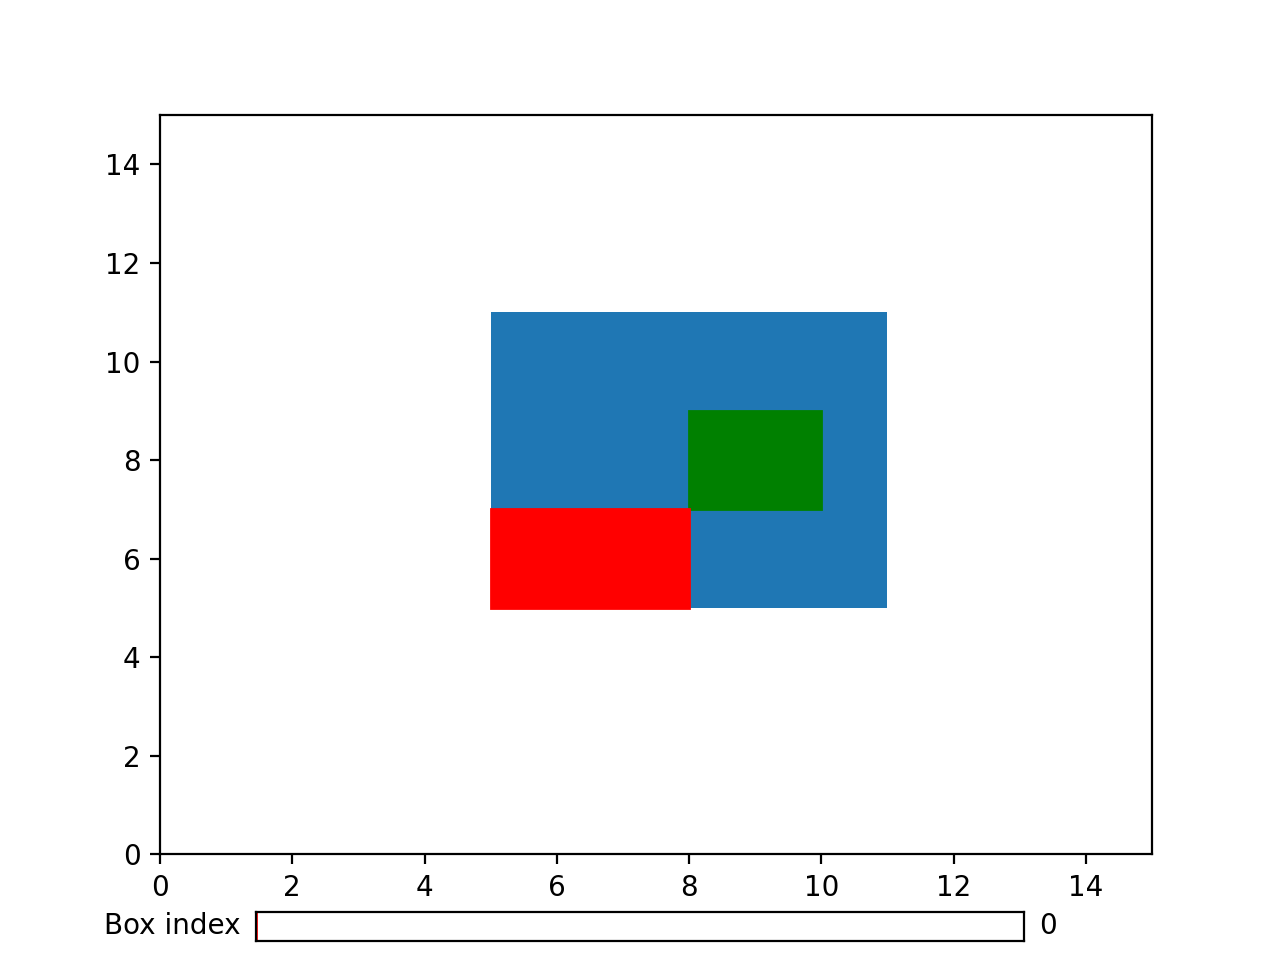

0

In [45]:
# Check the boxes
bb = eboxes[0]

fig, ax = plt.subplots()
ax.add_patch(plt.Rectangle(tuple(a.getMin()),a.getWidth(), a.getHeight()))
ax.add_patch(plt.Rectangle(tuple(b.getMin()),b.getWidth(), b.getHeight(), color = 'g'))
edgeboxP = plt.Rectangle(tuple(bb.getMin()),bb.getWidth(), bb.getHeight(), color = 'r')
ax.add_patch(edgeboxP)
ax.set_xlim(0, 15)
ax.set_ylim(0, 15)
axslider = plt.axes([0.2, 0.02, 0.6, 0.03])
slider = Slider(axslider,'Box index',0,7,valinit=0,valstep=1)

def update(val):
    global edgeboxP
    edgeboxP.remove()
    bb = eboxes[val]
    edgeboxP = plt.Rectangle(tuple(bb.getMin()),bb.getWidth(), bb.getHeight(), color = 'r')
    ax.add_patch(edgeboxP)
    
slider.on_changed(update)

In [343]:
def generateGrid(imageBox, minEdgeDims, innerBoxDims, minTotalDims=None, powerOfTwo=False):
    powerOf2 = np.array([16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192])
    doubleEdgeDims = minEdgeDims * 2
    xsize, ysize = imageBox.getDimensions()
    nX = xsize // innerBoxDims.x  # Round down
    if nX > 0:
        inXsize = xsize // nX  # Round down
    else:
        inXsize = xsize
        nX = 1
    xCorners = np.zeros(nX + 1)
    xCorners[:-1] = np.arange(nX)*inXsize + imageBox.minX 
    xCorners[-1] = imageBox.endX

    nY = ysize // innerBoxDims.y  # Round down
    if nY > 0:
        inYsize = ysize // nY  # Round down
    else:
        inYsize = ysize
        nY = 1
    yCorners = np.zeros(nY + 1)
    yCorners[:-1] = np.arange(nY)*inYsize + imageBox.minY 
    yCorners[-1] = imageBox.endY
    
    boxes = []
    
    for i_y in range(nY):
        for i_x in range(nX):
            innerBox = Box2I(Point2I(xCorners[i_x], yCorners[i_y]), 
                             Point2I(xCorners[i_x + 1] - 1, yCorners[i_y + 1] - 1))

            p2x = innerBox.width + doubleEdgeDims.x
            if minTotalDims is not None and p2x<minTotalDims.width:
                p2x = minTotalDims.width
            if powerOfTwo:
                i2x = np.searchsorted(powerOf2, p2x, side='left')
                if i2x < len(powerOf2):
                    p2x = powerOf2[i2x]
            totalXedge = p2x - innerBox.width
            
            p2y = innerBox.height + doubleEdgeDims.y
            if minTotalDims is not None and p2y<minTotalDims.height:
                p2y = minTotalDims.height
            if powerOfTwo:
                i2y = np.searchsorted(powerOf2, p2y, side='left')
                if i2y < len(powerOf2):
                    p2y = powerOf2[i2y]             
            totalYedge = p2y - innerBox.height
            outerBox = Box2I(Point2I(innerBox.minX - totalXedge//2, innerBox.minY - totalYedge//2),
                             Extent2I(p2x, p2y))
            boxes.append(Struct(innerBox=innerBox, outerBox=outerBox))
    return boxes

In [345]:
A = Box2I(Point2I(0,0), Extent2I(100, 100))

In [364]:
b1 = generateGrid(A, Extent2I(5, 5), Extent2I(30, 30), powerOfTwo=True)

In [365]:
b1

[Struct(innerBox=(minimum=(0, 0), maximum=(32, 32)); outerBox=(minimum=(-15, -15), maximum=(48, 48))),
 Struct(innerBox=(minimum=(33, 0), maximum=(65, 32)); outerBox=(minimum=(18, -15), maximum=(81, 48))),
 Struct(innerBox=(minimum=(66, 0), maximum=(99, 32)); outerBox=(minimum=(51, -15), maximum=(114, 48))),
 Struct(innerBox=(minimum=(0, 33), maximum=(32, 65)); outerBox=(minimum=(-15, 18), maximum=(48, 81))),
 Struct(innerBox=(minimum=(33, 33), maximum=(65, 65)); outerBox=(minimum=(18, 18), maximum=(81, 81))),
 Struct(innerBox=(minimum=(66, 33), maximum=(99, 65)); outerBox=(minimum=(51, 18), maximum=(114, 81))),
 Struct(innerBox=(minimum=(0, 66), maximum=(32, 99)); outerBox=(minimum=(-15, 51), maximum=(48, 114))),
 Struct(innerBox=(minimum=(33, 66), maximum=(65, 99)); outerBox=(minimum=(18, 51), maximum=(81, 114))),
 Struct(innerBox=(minimum=(66, 66), maximum=(99, 99)); outerBox=(minimum=(51, 51), maximum=(114, 114)))]

In [366]:
b1[0].outerBox.width

64

<IPython.core.display.Javascript object>


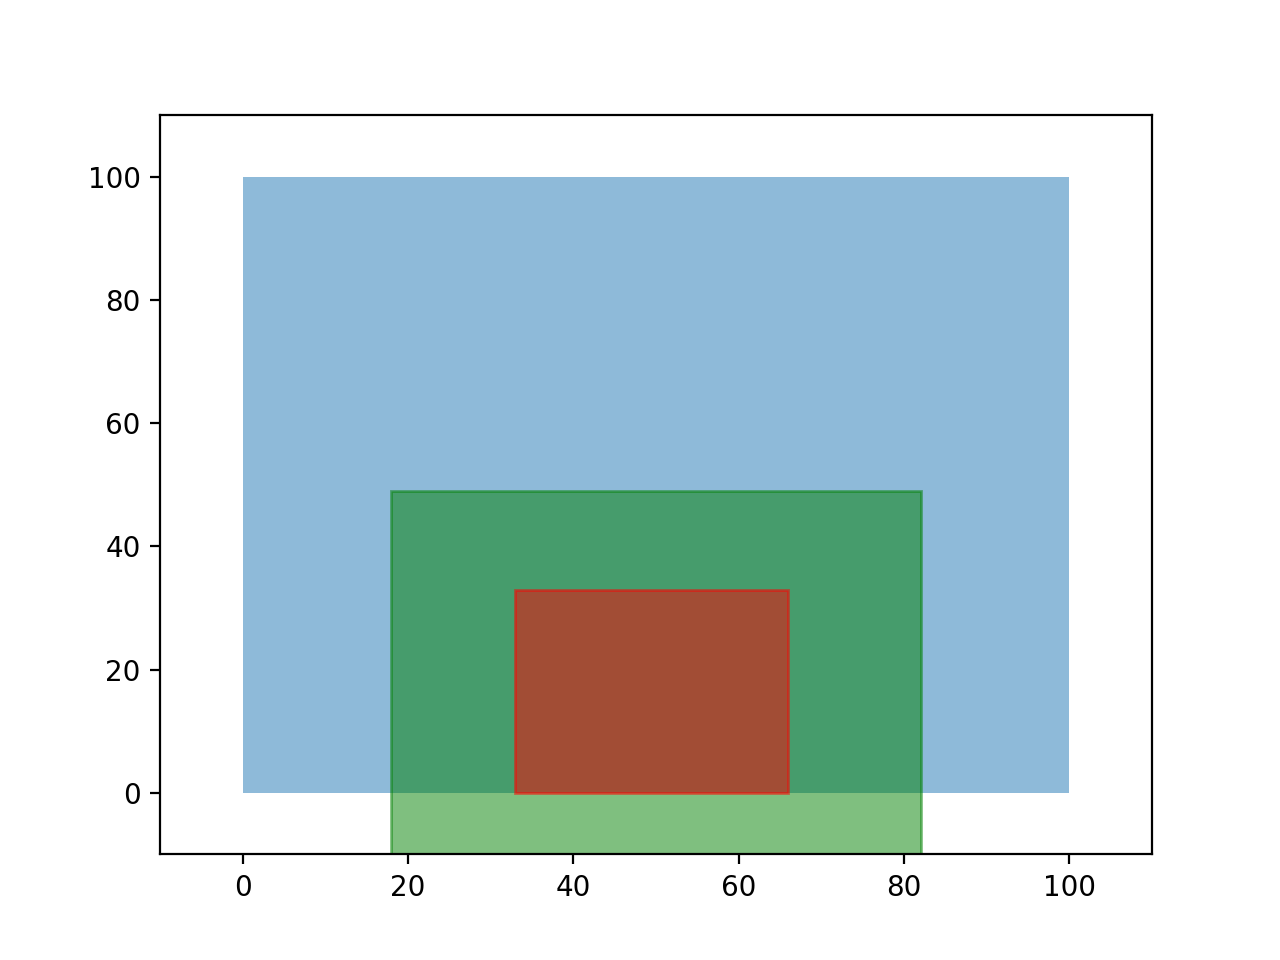

(-10.0, 110.0)

In [374]:
# Check the boxes
ib = b1[1].innerBox
ob = b1[1].outerBox

fig, ax = plt.subplots()
ax.add_patch(plt.Rectangle(tuple(A.getMin()),A.getWidth(), A.getHeight(), alpha=0.5))
ax.add_patch(plt.Rectangle(tuple(ob.getMin()),ob.getWidth(), ob.getHeight(), color = 'g', alpha=0.5))
ax.add_patch(plt.Rectangle(tuple(ib.getMin()),ib.getWidth(), ib.getHeight(), color = 'r', alpha=0.5))
ax.set_xlim(-10, 110)
ax.set_ylim(-10, 110)

In [375]:
eboxes = getEdgeBoxesSmaller(ib, ob)

In [376]:
for bb in eboxes:
    print(A.contains(bb))

False
False
False
True
True
True
True
True


In [373]:
print(ob.clippedTo(A))

(minimum=(0, 0), maximum=(48, 48))


In [5]:
np.array([ 1<<n for n in range(4,14)])

array([  16,   32,   64,  128,  256,  512, 1024, 2048, 4096, 8192])